In [1]:
import os
import pdfplumber
import pandas as pd
import matplotlib.pyplot as plt

def analyze_pdfs(directory):
    """
    Walk through all subfolders in 'directory', analyze each PDF:
    - count pages
    - count words
    - count images
    - count tables
    Handles corrupt or unreadable PDFs gracefully.
    Returns a pandas DataFrame with statistics and plots summary graphs.
    """
    records = []
    errors = []

    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.pdf'):
                path = os.path.join(root, file)
                rel_path = os.path.relpath(path, directory)
                try:
                    with pdfplumber.open(path) as pdf:
                        num_pages = len(pdf.pages)
                        total_words = 0
                        total_images = 0
                        total_tables = 0

                        for page_num, page in enumerate(pdf.pages, start=1):
                            try:
                                text = page.extract_text() or ""
                                total_words += len(text.split())
                                total_images += len(page.images)
                                total_tables += len(page.extract_tables())
                            except Exception as pe:
                                # Skip problematic page
                                print(f"Warning: couldn't parse page {page_num} of {rel_path}: {pe}")

                    records.append({
                        'file': rel_path,
                        'pages': num_pages,
                        'words': total_words,
                        'images': total_images,
                        'tables': total_tables,
                        'error': None
                    })
                except Exception as e:
                    # Log error and continue
                    print(f"Error: couldn't open or process '{rel_path}': {e}")
                    errors.append((rel_path, str(e)))
                    records.append({
                        'file': rel_path,
                        'pages': None,
                        'words': None,
                        'images': None,
                        'tables': None,
                        'error': str(e)
                    })

    df = pd.DataFrame(records)
    if df.empty:
        print("No PDF files found in the specified directory.")
        return df

    # Report any errors
    if errors:
        print(f"Encountered errors in {len(errors)} files:")
        for fp, err in errors:
            print(f" - {fp}: {err}")

    # Display basic statistics for successfully parsed PDFs
    stats = df[df['error'].isnull()][['pages', 'words', 'images', 'tables']]
    print("PDF Analysis Summary (successful files):")
    print(stats.describe())

    # Plot histograms for each metric
    metrics = ['pages', 'words', 'images', 'tables']
    for metric in metrics:
        plt.figure()
        stats[metric].dropna().hist(bins=10)
        plt.title(f'Distribution of {metric.capitalize()} per PDF')
        plt.xlabel(metric.capitalize())
        plt.ylabel('Count')
        plt.tight_layout()
        plt.show()

    # Plot a scatter of words vs pages
    plt.figure()
    plt.scatter(stats['pages'], stats['words'], alpha=0.7)
    plt.title('Words vs Pages')
    plt.xlabel('Pages')
    plt.ylabel('Words')
    plt.tight_layout()
    plt.show()

    return df

Error: couldn't open or process 'alarms-buzzers-and-sirens/cem-1201-42-/cem-1201-42-.pdf': Unexpected EOF
Encountered errors in 1 files:
 - alarms-buzzers-and-sirens/cem-1201-42-/cem-1201-42-.pdf: Unexpected EOF
PDF Analysis Summary (successful files):
            pages          words       images       tables
count  752.000000     752.000000   752.000000   752.000000
mean     5.102394    1371.484043    18.134309    14.187500
std     25.407127   14375.337878   111.085813   166.432188
min      1.000000       0.000000     0.000000     0.000000
25%      1.000000     242.000000     2.000000     1.000000
50%      2.000000     418.000000     3.000000     4.000000
75%      5.000000     603.250000     8.000000     8.000000
max    656.000000  385859.000000  2779.000000  4506.000000


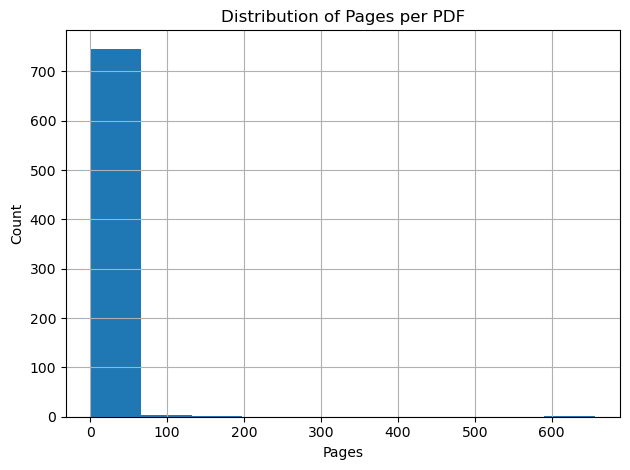

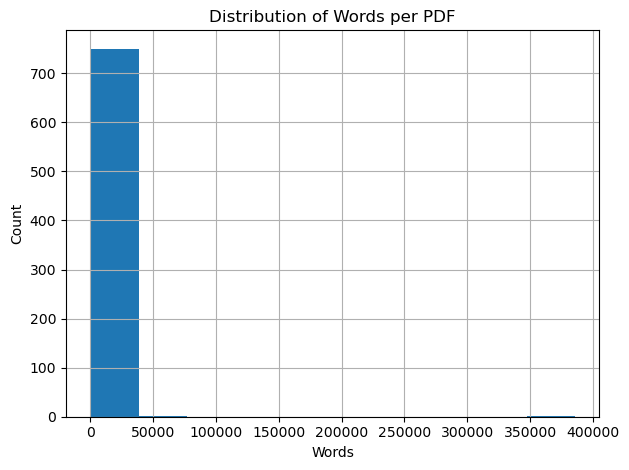

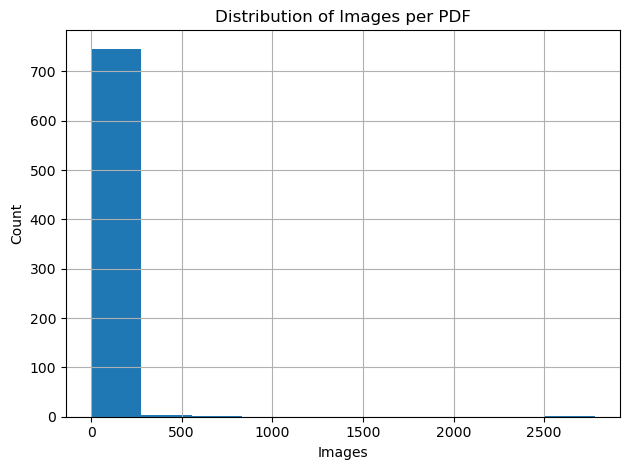

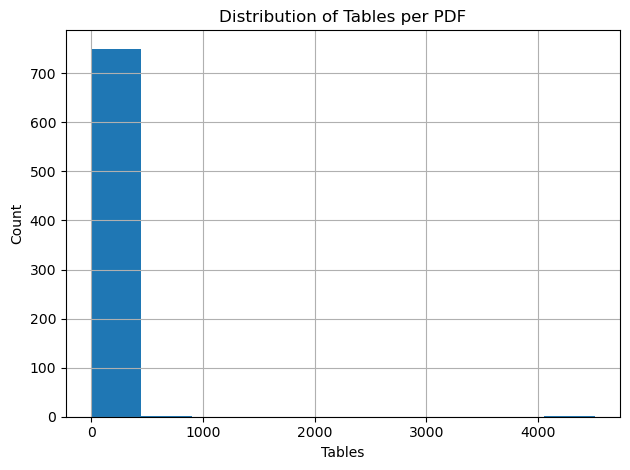

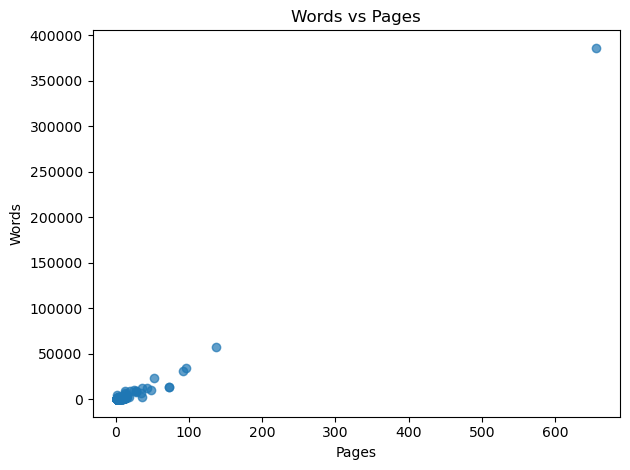

file  pages   words  images  \
0    alarms-buzzers-and-sirens/cmt-13031-smt-tr/cmt...    4.0   610.0   264.0   
1    alarms-buzzers-and-sirens/css-i4b20-smt-tr/css...    4.0   634.0     1.0   
2    alarms-buzzers-and-sirens/AT-1224-TWT-12V-2-R/...    5.0   453.0     8.0   
3        alarms-buzzers-and-sirens/cc-0601/cc-0601.pdf    3.0   424.0     2.0   
4    alarms-buzzers-and-sirens/cem-1201-42-/cem-120...    NaN     NaN     NaN   
..                                                 ...    ...     ...     ...   
748  controller-accesories/DELTA_IA-TC_DTB_OM_EN_20...   13.0  6222.0   273.0   
749  controller-accesories/e145023ac513ab7a8633a15e...    2.0   396.0     8.0   
750  controller-accesories/e1bc23b6b1f102bc6809deab...    3.0   871.0     3.0   
751  controller-accesories/e31e335aa360e3072b98cbbd...    2.0   394.0     7.0   
752  controller-accesories/e3c6f1323fc3b07507a157e0...    3.0   567.0     3.0   

     tables           error  
0       5.0            None  
1       6.0            None  
2       3.0            None  
3       3.0            None  
4       NaN  Unexpected EOF  
..      ...             ...  
748    38.0            None  
749     0.0            None  
750     3.0            None  
751     0.0            None  
752     3.0            None  

[753 rows x 6 columns]

In [2]:
analyze_pdfs("../02-data/00-testing")

In [1]:
import os
import json

# Base directory containing labeled subfolders
def generate_mapping(base_dir):
    """
    Walk through the base directory and generate a mapping from each file-folder
    name to its parent label.

    Args:
        base_dir (str): Path to the root directory (e.g., '00-testing').

    Returns:
        dict: Mapping where keys are file-folder names and values are labels.
    """
    mapping = {}

    # Iterate over each label folder
    for label in os.listdir(base_dir):
        label_path = os.path.join(base_dir, label)
        if not os.path.isdir(label_path):
            continue

        # Iterate over each file folder inside the label
        for file_folder in os.listdir(label_path):
            file_folder_path = os.path.join(label_path, file_folder)
            if not os.path.isdir(file_folder_path):
                continue

            # Map the file-folder name (e.g., 'file1') to its label (e.g., 'label1')
            mapping[file_folder] = label

    return mapping


In [5]:
import pickle

def save_mapping_pickle(mapping, output_path):
    """
    Save the mapping dictionary to a pickle file.
    """
    with open(output_path, 'wb') as f:
        pickle.dump(mapping, f)
    print(f"Mapping saved to {output_path} ({len(mapping)} entries)")


def load_mapping_pickle(input_path):
    """
    Load the mapping dictionary from a pickle file.
    """
    with open(input_path, 'rb') as f:
        return pickle.load(f)


def print_label_counts(mapping):
    """
    Print the number of documents per label using pandas.
    """
    df = pd.DataFrame.from_dict(mapping, orient='index', columns=['label'])
    counts = df['label'].value_counts()
    print("Documents per label:")
    print(counts)


In [8]:
import pandas as pd

base_directory = '../02-data/00-testing/'
pickle_path = '../02-data/00-testing/file_to_label.pkl'

# Generate the mapping
file_label_map = generate_mapping(base_directory)

# Save the mapping to a pickle file
save_mapping_pickle(file_label_map, pickle_path)

# Load the mapping back and print label counts
loaded_map = load_mapping_pickle(pickle_path)
print_label_counts(loaded_map)


Mapping saved to ../02-data/00-testing/file_to_label.pkl (755 entries)
Documents per label:
label
batteries-non-rechargable-primary    152
speakers                             150
controller-accesories                150
microphones                          136
coaxial-cables-rf                     45
printers-label-makers                 45
cable-ties-zip-ties                   39
alarms-buzzers-and-sirens             38
Name: count, dtype: int64


In [18]:
files = ["../02-data/03-VSM/01-Word2Vec/word2vec-4-50-4-150-0.pkl",
     "../02-data/03-VSM/01-Word2Vec/word2vec-4-50-4-150-1.pkl"]


def load_document_vectors(file_path: str):
    """Loads document vectors from a given pickle file."""
    try:
        with open(file_path, "rb") as f:
            return pickle.load(f)
    except Exception as e:
        return None
    
for file_path in files:
    print(file_path)
    document_vectors = load_document_vectors(file_path)
    if document_vectors is not None:
        doc_names = list(document_vectors.keys())
        print(doc_names)

../02-data/03-VSM/01-Word2Vec/word2vec-4-50-4-150-0.pkl
['cmt-13031-smt-tr', 'css-i4b20-smt-tr', 'AT-1224-TWT-12V-2-R', 'cc-0601', 'cem-1203-42-', 'cem-1205-ic', 'cem-1212s', 'cep-1110', 'cep-1112', 'cep-2202a', 'cmi-1295ic-1285t', 'cmi-9605-1280t', 'cmi-9605ic-0580t', 'cmi-9650c-030', 'cmi-9653s-smt-tr', 'cmi-9655s-smt-tr', 'cmi-9705-0380-smt-tr', 'cmt-0926-86-smt-tr', 'cmt-4023s-smt-tr', 'cmt-7525-80-smt-tr', 'cpe-200', 'cpe-203', 'cpi-1514-12-95t', 'cpi-2212-85pm', 'cps-4013-110pm', 'cpt-3011c-120', 'cpt-9019a-smt-tr', 'cpt-9019b-smt-tr', 'css-0578-smt-tr', 'cx-1612c', 'GT-0905A-19-Feb-2019', 'GT-111P-14-Feb-2019', 'IP223309-1', 'SPEC-PKLCS1212E4001-R1', 'TP094003-1', 'WST-1205S-17-Feb-2019', 'WST-1212S-17-Feb-2019', '123', '1cr2', '27ASPEC', '2cr5_spec_sheet', '357-303zb', '386-301', '392-384z', '397-396', 'A10MF', 'A13MF', 'a23', 'A312MF', 'A675MF', 'A675PMF', 'a76z', 'AAA4000C182', 'AAA4000C186', 'AAA4000C202', 'AAA4000C206', 'AAA4000C222', 'AAA4000C226', 'AAA4000C234', 'AAA4000C

In [13]:
document_vectors

In [ ]:
import pickle
import numpy as np
import logging
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve, validation_curve
import os

import matplotlib.pyplot as plt

# Configure logging
# Configure logging to both console and file
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[
                        logging.StreamHandler(),  # Log to console
                        logging.FileHandler("../02-data/04-Classifier/preeliminary_classification.txt")  # Log to file
                    ])

# Base directory containing labeled subfolders
def generate_mapping(base_dir):
    """
    Walk through the base directory and generate a mapping from each file-folder
    name to its parent label.

    Args:
        base_dir (str): Path to the root directory (e.g., '00-testing').

    Returns:
        dict: Mapping where keys are file-folder names and values are labels.
    """
    mapping = {}

    # Iterate over each label folder
    for label in os.listdir(base_dir):
        label_path = os.path.join(base_dir, label)
        if not os.path.isdir(label_path):
            continue

        # Iterate over each file folder inside the label
        for file_folder in os.listdir(label_path):
            file_folder_path = os.path.join(label_path, file_folder)
            if not os.path.isdir(file_folder_path):
                continue

            # Map the file-folder name (e.g., 'file1') to its label (e.g., 'label1')
            mapping[file_folder] = label

    return mapping

def save_mapping_pickle(mapping, output_path):
    """
    Save the mapping dictionary to a pickle file.
    """
    with open(output_path, 'wb') as f:
        pickle.dump(mapping, f)
    print(f"Mapping saved to {output_path} ({len(mapping)} entries)")


def load_mapping_pickle(input_path):
    """
    Load the mapping dictionary from a pickle file.
    """
    with open(input_path, 'rb') as f:
        return pickle.load(f)

def plot_learning_curve(name, best_model, X_train, y_train):
    """Plot the learning curve for the classifier."""
    train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, n_jobs=-1)

    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training score')
    plt.plot(train_sizes, test_scores.mean(axis=1), label='Test score')
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title(f'{name} Learning Curve')
    plt.legend()
    plt.show()

def plot_validation_curve(name, best_model, X_train, y_train):
    """Plot the validation curve for the classifier."""
    if 'C' not in best_model.get_params():
        logging.warning(f"{'C'} is not a valid parameter for {name}. Skipping validation curve plot.")
        return

    param_range = [0.1, 1, 10]
    train_scores, test_scores = validation_curve(best_model, X_train, y_train, param_name='C', param_range=param_range, cv=5)

    plt.plot(param_range, train_scores.mean(axis=1), label='Train score')
    plt.plot(param_range, test_scores.mean(axis=1), label='Test score')
    plt.xlabel('C Parameter')
    plt.ylabel('Accuracy')
    plt.title(f'{name} Validation Curve')
    plt.legend()
    plt.show()

## This is super shitty and prone to break -- should refactor it and get a dictionary of the files and their labels
def extract_category(file_name: str, mapping: dict) -> str:
    """
    Retrieves the label/category for a given file-folder name using a mapping.

    Args:
        file_name (str): The name of the file-folder (e.g., 'file1').
        mapping (dict): A dictionary mapping file-folder names to labels.

    Returns:
        str: The label associated with the given file-folder, or an empty string if not found.
    """
    label = mapping.get(file_name)
    if label is None:
        logging.warning(f"No label found for file: {file_name}")
        return ""
    return label

def load_document_vectors(file_path: str):
    """Loads document vectors from a given pickle file."""
    try:
        with open(file_path, "rb") as f:
            return pickle.load(f)
    except Exception as e:
        logging.error(f"Error loading file {file_path}: {e}")
        return None

def train_and_evaluate_classifiers(doc_vectors, doc_paths, file_name, results, mapping):
    """
    Trains and evaluates Logistic Regression, SVM, and Random Forest classifiers using GridSearchCV.

    Args:
        doc_vectors (dict): Dictionary of document vectors.
        doc_paths (list): List of document file paths.
        file_name (str): Name of the file being processed.
        results (list): List to store results.
    """
    # Convert document vectors to array and extract labels
    X = np.array(list(doc_vectors.values()))
    y_labels = [extract_category(doc,mapping) for doc in doc_paths]

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_labels)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Auxiliary Checks
    logging.info(f"Class distribution in training set: {dict(sorted(Counter(y_train).items()))}")
    logging.info(f"Class distribution in test set: {dict(sorted(Counter(y_test).items()))}")
    logging.info(f"Mean Cosine Similarity in Training Set: {cosine_similarity(X_train).mean():.4f}")

    param_grids = {
        "Logistic Regression": {
            'C': [0.1, 1, 10],
            'max_iter': [500, 1000]
        },
        "SVM": {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        },
        "Random Forest": {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20]
        }
    }

    classifiers = {
        "Logistic Regression": LogisticRegression(),
        "SVM": SVC(),
        "Random Forest": RandomForestClassifier()
    }

    for name, clf in classifiers.items():
        logging.info(f" ----------- Training {name} -----------")

        grid_search = GridSearchCV(clf, param_grids[name], cv=5, scoring='accuracy')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        cross_val_scores = cross_val_score(best_model, X_train, y_train, cv=5)

        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        logging.info(f"{name} Best Params: {grid_search.best_params_}")
        logging.info(f"{name} Cross-validation Accuracy: {cross_val_scores.mean():.4f} ± {cross_val_scores.std():.4f}")
        logging.info(f"{name} Test Set Accuracy: {accuracy:.4f}")

        # Additional evaluations
        logging.info(f"{name} Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")
        logging.info(
            f"{name} Classification Report: \n{classification_report(y_test, y_pred, target_names=label_encoder.classes_)}")

        # For ROC AUC (binary classification)
        if len(np.unique(y)) == 2:
            fpr, tpr, _ = roc_curve(y_test, y_pred)
            roc_auc = auc(fpr, tpr)
            logging.info(f"{name} ROC AUC: {roc_auc:.4f}")

        # Plot learning and validation curves
        plot_learning_curve(name, best_model, X_train, y_train)
        plot_validation_curve(name, best_model, X_train, y_train)

        result_record = {
            "file_name": file_name,
            "classifier": name,
            "best_params": grid_search.best_params_,
            "accuracy": accuracy,
            "train_class_distribution": dict(sorted(Counter(y_train).items())),
            "test_class_distribution": dict(sorted(Counter(y_test).items())),
            "mean_cosine_similarity_train": cosine_similarity(X_train).mean(),
            "cross_val_accuracy": cross_val_scores.mean(),
            "cross_val_std": cross_val_scores.std(),
            "confusion_matrix": confusion_matrix(y_test, y_pred),  # You may convert this if needed.
            "classification_report": classification_report(
                y_test, y_pred, target_names=label_encoder.classes_
            )
        }

        # Append the flat dictionary to your results list.
        results.append(result_record)

if __name__ == "__main__":
    files = ["../02-data/03-VSM/01-Word2Vec/word2vec-4-50-4-150.pkl",
             "../02-data/03-VSM/02-Glove/glove-4-50-4-150.pkl",
             "../02-data/03-VSM/03-Fasttext/fasttext-4-50-4-150.pkl"]

    files = ["../02-data/03-VSM/01-Word2Vec/word2vec-4-50-4-150-0.pkl",
             "../02-data/03-VSM/01-Word2Vec/word2vec-4-50-4-150-1.pkl"]

    save_path = "../02-data/04-Classifier/classifiers-4-50-4-150.csv"

    results = []

    mapping = generate_mapping("../02-data/00-testing/") ## same files that where used to create the .pkl
    save_mapping_pickle(mapping, f"../02-data/mapping")

    for file_path in files:
        document_vectors = load_document_vectors(file_path)
        if document_vectors is not None:
            doc_paths = list(document_vectors.keys())
            logging.info(f"=========== Training with VSM {file_path} ===========")
            train_and_evaluate_classifiers(document_vectors, doc_paths, os.path.basename(file_path), results,mapping)

    df_results = pd.DataFrame(results)
    df_results.to_csv(save_path, index=False)
    logging.info(f"Results saved to {save_path}")

